In [1]:
# importing libraries
import pandas as pd
import numpy as np
import re
from tqdm import tqdm_notebook
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from scipy import sparse
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.naive_bayes import MultinomialNB
from prettytable import PrettyTable

In [2]:
# sampling 100000 data points
project_data = pd.read_csv('train_data.csv').sample(n=100000)
resource_data = pd.read_csv('resources.csv')

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [3]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

In [4]:
# train test cv split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.2, stratify=y_train)

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(64000, 18) (64000,)
(16000, 18) (16000,)
(20000, 18) (20000,)


In [5]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [7]:
def preprocess_text(text):
    preprocessed_text = []
    for sent in text:
        sent = decontracted(sent)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [8]:
feature_list_bow = []
feature_list_tfidf = []

### 1. Essay

In [9]:
def preprocess_essays(df):
    df['essay'] = df['project_essay_1'].map(str) +\
                  df['project_essay_2'].map(str) +\
                  df['project_essay_3'].map(str) +\
                  df['project_essay_4'].map(str)

    df['clean_essay'] = preprocess_text(df['essay'].values)
    
preprocess_essays(X_train)
preprocess_essays(X_cv)
preprocess_essays(X_test)

# bow
bow_model = CountVectorizer(min_df=10, max_features=10000)
bow_model.fit(X_train['clean_essay'].values)

X_train_essay_bow = bow_model.transform(X_train['clean_essay'].values)
X_cv_essay_bow = bow_model.transform(X_cv['clean_essay'].values)
X_test_essay_bow = bow_model.transform(X_test['clean_essay'].values)

feature_list_bow.extend(bow_model.get_feature_names())

print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

(64000, 10000) (64000,)
(16000, 10000) (16000,)
(20000, 10000) (20000,)


In [10]:
# tfidf
tfidf_model = TfidfVectorizer(min_df=10, max_features=10000)
tfidf_model.fit(X_train['clean_essay'].values)

X_train_essay_tfidf = tfidf_model.transform(X_train['clean_essay'].values)
X_cv_essay_tfidf = tfidf_model.transform(X_cv['clean_essay'].values)
X_test_essay_tfidf = tfidf_model.transform(X_test['clean_essay'].values)

feature_list_tfidf.extend(tfidf_model.get_feature_names())

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(64000, 10000) (64000,)
(16000, 10000) (16000,)
(20000, 10000) (20000,)


### 2. Teacher Prefix

In [11]:
def preprocess_teacher_prefix(df):
    df['teacher_prefix'] = df['teacher_prefix'].fillna('Mrs.')
    df['teacher_prefix'] = df['teacher_prefix'].str.replace('.', '')
    df['clean_teacher_prefix'] = df['teacher_prefix'].str.lower()

preprocess_teacher_prefix(X_train)
preprocess_teacher_prefix(X_cv)
preprocess_teacher_prefix(X_test)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_teacher_prefix'].values)

X_train_teacher_ohe = vectorizer.transform(X_train['clean_teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['clean_teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['clean_teacher_prefix'].values)

feature_list_bow.extend(vectorizer.get_feature_names())
feature_list_tfidf.extend(vectorizer.get_feature_names())

print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)

(64000, 5) (64000,)
(16000, 5) (16000,)
(20000, 5) (20000,)


### 3. Teacher Grade Category

In [12]:
def preprocess_project_grade_category(df):
    # cleaning
    df['project_grade_category'] = df['project_grade_category'].str.replace(' ', '_')
    df['project_grade_category'] = df['project_grade_category'].str.replace('-', '_')
    df['clean_project_grade_category'] = df['project_grade_category'].str.lower()

preprocess_project_grade_category(X_train)
preprocess_project_grade_category(X_cv)
preprocess_project_grade_category(X_test)

# encoding using one hot encoding
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_project_grade_category'].values)

X_train_grade_ohe = vectorizer.transform(X_train['clean_project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['clean_project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['clean_project_grade_category'].values)

feature_list_bow.extend(vectorizer.get_feature_names())
feature_list_tfidf.extend(vectorizer.get_feature_names())

print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)

(64000, 4) (64000,)
(16000, 4) (16000,)
(20000, 4) (20000,)


### 4. School State

In [13]:
def preprocess_school_state(df):
    df['school_state'] = df['school_state'].str.lower()

preprocess_school_state(X_train)
preprocess_school_state(X_cv)
preprocess_school_state(X_test)

# encoding using one hot encoder
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

feature_list_bow.extend(vectorizer.get_feature_names())
feature_list_tfidf.extend(vectorizer.get_feature_names())

print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)

(64000, 51) (64000,)
(16000, 51) (16000,)
(20000, 51) (20000,)


### 5. Project Subject Categories

In [14]:
def preprocess_project_subject_categories(df):
    # cleaning
    df['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The', '')
    df['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ', '')
    df['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&', '_')
    df['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',', '_')
    df['clean_project_subject_categories'] = project_data['project_subject_categories'].str.lower()

preprocess_project_subject_categories(X_train)
preprocess_project_subject_categories(X_cv)
preprocess_project_subject_categories(X_test)

# encoding using one hot encoding
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_project_subject_categories'].values)

X_train_subject_ohe = vectorizer.transform(X_train['clean_project_subject_categories'].values)
X_cv_subject_ohe = vectorizer.transform(X_cv['clean_project_subject_categories'].values)
X_test_subject_ohe = vectorizer.transform(X_test['clean_project_subject_categories'].values)

feature_list_bow.extend(vectorizer.get_feature_names())
feature_list_tfidf.extend(vectorizer.get_feature_names())

print(X_train_subject_ohe.shape, y_train.shape)
print(X_cv_subject_ohe.shape, y_cv.shape)
print(X_test_subject_ohe.shape, y_test.shape)

(64000, 18) (64000,)
(16000, 18) (16000,)
(20000, 18) (20000,)


### 6. Project Subject Subcategories

In [15]:
def preprocess_project_subject_subcategories(df):
    df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace(' The', '')
    df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace(' ','')
    df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace('&', '_')
    df['project_subject_subcategories'] = df['project_subject_subcategories'].str.replace(',', '_')
    df['clean_project_subject_subcategories'] = df['project_subject_subcategories'].str.lower()

preprocess_project_subject_subcategories(X_train)
preprocess_project_subject_subcategories(X_cv)
preprocess_project_subject_subcategories(X_test)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_project_subject_subcategories'].values)

X_train_subject_subcategories_ohe = vectorizer.transform(X_train['clean_project_subject_subcategories'].values)
X_cv_subject_subcategories_ohe = vectorizer.transform(X_cv['clean_project_subject_subcategories'].values)
X_test_subject_subcategories_ohe = vectorizer.transform(X_test['clean_project_subject_subcategories'].values)

feature_list_bow.extend(vectorizer.get_feature_names())
feature_list_tfidf.extend(vectorizer.get_feature_names())

print(X_train_subject_subcategories_ohe.shape, y_train.shape)
print(X_train_subject_subcategories_ohe.shape, y_cv.shape)
print(X_train_subject_subcategories_ohe.shape, y_test.shape)

(64000, 387) (64000,)
(64000, 387) (16000,)
(64000, 387) (20000,)


### 7. Price

In [16]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_temp = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_temp = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_temp = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_normalized = X_train_price_temp.reshape(-1,1)
X_cv_price_normalized = X_cv_price_temp.reshape(-1,1)
X_test_price_normalized = X_test_price_temp.reshape(-1,1)

feature_list_bow.append('Price')
feature_list_tfidf.append('Price')

print(X_train_price_normalized.shape, y_train.shape)
print(X_cv_price_normalized.shape, y_train.shape)
print(X_test_price_normalized.shape, y_train.shape)

(64000, 1) (64000,)
(16000, 1) (64000,)
(20000, 1) (64000,)


### 8. Teacher number of previously posted projects

In [17]:
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_price_temp = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_price_temp = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_price_temp = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_temp.reshape(-1,1)
X_cv_prev_proj_norm = X_cv_price_temp.reshape(-1,1)
X_test_prev_proj_norm = X_test_price_temp.reshape(-1,1)

feature_list_bow.append('teacher_number_of_previously_posted_projects')
feature_list_tfidf.append('teacher_number_of_previously_posted_projects')

print(X_train_prev_proj_norm.shape, y_train.shape)
print(X_cv_prev_proj_norm.shape, y_train.shape)
print(X_test_prev_proj_norm.shape, y_train.shape)

(64000, 1) (64000,)
(16000, 1) (64000,)
(20000, 1) (64000,)


In [18]:
# combining features
X_train_bow = hstack((X_train_teacher_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_subject_ohe, X_train_subject_subcategories_ohe, X_train_price_normalized, X_train_prev_proj_norm, X_train_essay_bow)).tocsr()
X_cv_bow = hstack((X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_state_ohe, X_cv_subject_ohe, X_cv_subject_subcategories_ohe, X_cv_price_normalized, X_cv_prev_proj_norm, X_cv_essay_bow)).tocsr()
X_test_bow = hstack((X_test_teacher_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_subject_ohe, X_test_subject_subcategories_ohe, X_test_price_normalized, X_test_prev_proj_norm, X_test_essay_bow)).tocsr()

print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

(64000, 10467) (64000,)
(16000, 10467) (16000,)
(20000, 10467) (20000,)


In [19]:
# combining features
X_train_tfidf = hstack((X_train_teacher_ohe, X_train_grade_ohe, X_train_state_ohe, X_train_subject_ohe, X_train_subject_subcategories_ohe, X_train_price_normalized, X_train_prev_proj_norm, X_train_essay_tfidf)).tocsr()
X_cv_tfidf = hstack((X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_state_ohe, X_cv_subject_ohe, X_cv_subject_subcategories_ohe, X_cv_price_normalized, X_cv_prev_proj_norm, X_cv_essay_tfidf)).tocsr()
X_test_tfidf = hstack((X_test_teacher_ohe, X_test_grade_ohe, X_test_state_ohe, X_test_subject_ohe, X_test_subject_subcategories_ohe, X_test_price_normalized, X_test_prev_proj_norm, X_test_essay_tfidf)).tocsr()

print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

(64000, 10467) (64000,)
(16000, 10467) (16000,)
(20000, 10467) (20000,)


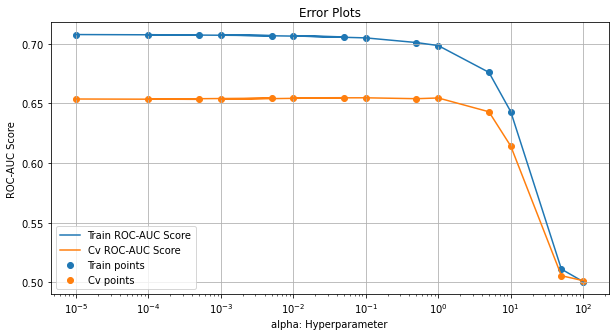

In [20]:
# using first set of features (BOW)
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

train_auc_bow = []
cv_auc_bow = []

for i in tqdm_notebook(alpha):
    classifier_bow = MultinomialNB(alpha=i, class_prior=[0.5, 0.5])
    classifier_bow.fit(X_train_bow, y_train)
    
    y_train_pred = classifier_bow.predict(X_train_bow)
    y_cv_pred = classifier_bow.predict(X_cv_bow)
    
    train_auc_bow.append(roc_auc_score(y_train, y_train_pred))
    cv_auc_bow.append(roc_auc_score(y_cv, y_cv_pred))

plt.figure(figsize=(10,5))
plt.plot(alpha, train_auc_bow, label='Train ROC-AUC Score')
plt.plot(alpha, cv_auc_bow, label='Cv ROC-AUC Score')

plt.scatter(alpha, train_auc_bow, label='Train points')
plt.scatter(alpha, cv_auc_bow, label='Cv points')

plt.legend()
plt.xscale('log')
plt.xlabel('alpha: Hyperparameter')
plt.ylabel('ROC-AUC Score')
plt.title('Error Plots')
plt.grid()
plt.show()

Best alpha is:  1e-05
Max AUC:  0.7077510582481161


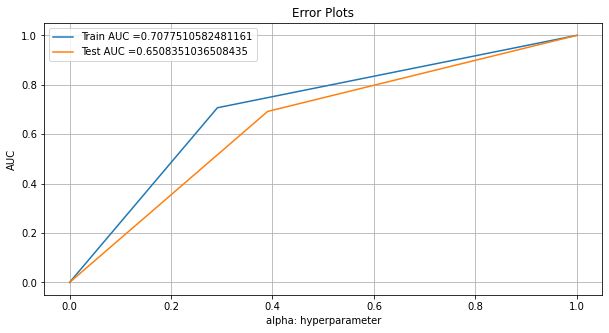

In [21]:
# best alpha is the one with maximum auc value
best_alpha_bow =alpha[np.argmax(train_auc_bow)]
print('Best alpha is: ', best_alpha_bow)

classifier_bow = MultinomialNB(alpha=best_alpha_bow, class_prior=[0.5, 0.5])
classifier_bow.fit(X_train_bow, y_train)

y_train_pred = classifier_bow.predict(X_train_bow)
y_test_pred = classifier_bow.predict(X_test_bow)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

auc_bow = auc(train_fpr, train_tpr)
print('Max AUC: ', str(auc_bow))

plt.figure(figsize=(10,5))
plt.plot(train_fpr, train_tpr, label='Train AUC ='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC ='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.grid()
plt.show()

In [22]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print('The maximum value of tpr*(1-fpr)', max(tpr*(1-fpr)), 'for threshold', np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [23]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) 0.5009109781334281 for threshold 1
Train confusion matrix:
[[ 6857  2821]
 [15917 38405]]
Test confusion matrix:
[[ 1843  1181]
 [ 5225 11751]]


In [24]:
# https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plotConfusionMatrix(matrix):
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Rejected','Accepted'])
    ax.yaxis.set_ticklabels(['Rejected','Accepted'])

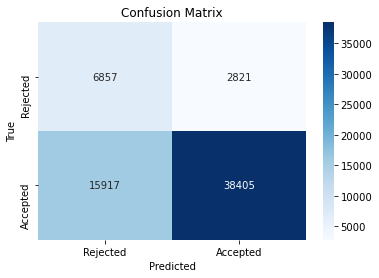

In [25]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
plotConfusionMatrix(train_matrix)

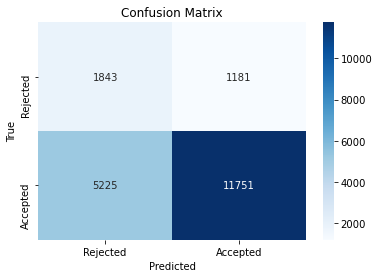

In [26]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
plotConfusionMatrix(test_matrix)

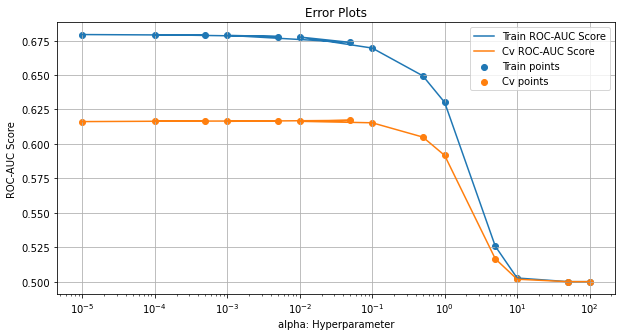

In [27]:
# using second set of features (TFIDF)
alpha = [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

train_auc_tfidf = []
cv_auc_tfidf = []

for i in tqdm_notebook(alpha):
    classifier_tfidf = MultinomialNB(alpha=i, class_prior=[0.5, 0.5])
    classifier_tfidf.fit(X_train_tfidf, y_train)
    
    y_train_pred = classifier_tfidf.predict(X_train_tfidf)
    y_cv_pred = classifier_tfidf.predict(X_cv_tfidf)
    
    train_auc_tfidf.append(roc_auc_score(y_train, y_train_pred))
    cv_auc_tfidf.append(roc_auc_score(y_cv, y_cv_pred))

plt.figure(figsize=(10,5))
plt.plot(alpha, train_auc_tfidf, label='Train ROC-AUC Score')
plt.plot(alpha, cv_auc_tfidf, label='Cv ROC-AUC Score')

plt.scatter(alpha, train_auc_tfidf, label='Train points')
plt.scatter(alpha, cv_auc_tfidf, label='Cv points')

plt.legend()
plt.xscale('log')
plt.xlabel('alpha: Hyperparameter')
plt.ylabel('ROC-AUC Score')
plt.title('Error Plots')
plt.grid()
plt.show()

Best alpha is:  1e-05
Max AUC:  0.6793985051396774


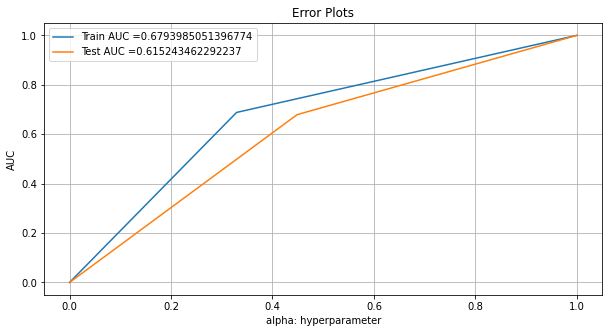

In [28]:
best_alpha_tfidf=alpha[np.argmax(train_auc_tfidf)]
print('Best alpha is: ', best_alpha_tfidf)

classifier_tfidf = MultinomialNB(alpha=best_alpha_tfidf, class_prior=[0.5, 0.5])
classifier_tfidf.fit(X_train_tfidf, y_train)

y_train_pred = classifier_tfidf.predict(X_train_tfidf)
y_test_pred = classifier_tfidf.predict(X_test_tfidf)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

auc_tfidf = auc(train_fpr, train_tpr)
print('Max AUC: ', str(auc_tfidf))

plt.figure(figsize=(10,5))
plt.plot(train_fpr, train_tpr, label='Train AUC ='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC ='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.grid()
plt.show()

In [29]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)

print('Train confusion matrix:')
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print('Test confusion matrix:')
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) 0.46150660258520293 for threshold 1
Train confusion matrix:
[[ 6491  3187]
 [16943 37379]]
Test confusion matrix:
[[ 1668  1356]
 [ 5451 11525]]


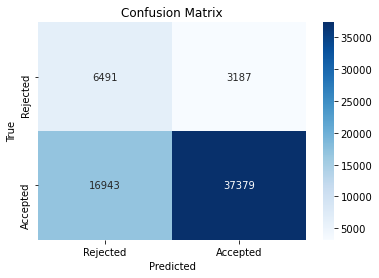

In [30]:
train_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
plotConfusionMatrix(train_matrix)

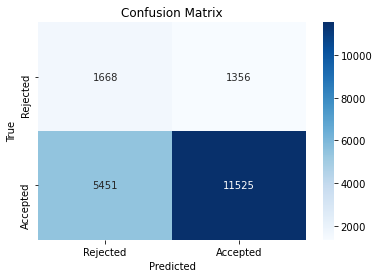

In [31]:
test_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
plotConfusionMatrix(test_matrix)

In [32]:
# printing top 20 BOW features for negative and positive class
negative_bow = classifier_bow.feature_log_prob_[0]
top_20_negative_bow = np.argsort(negative_bow)[::-1][:20]
top_20_negative_bow_features = [feature_list_bow[i] for i in top_20_negative_bow]
print('\nTop 20 features for rejecting projects using BOW are: \n', top_20_negative_bow_features, '\n')

print('-'*100)

positive_bow = classifier_bow.feature_log_prob_[1]
top_20_positive_bow = np.argsort(positive_bow)[::-1][:20]
top_20_positive_bow_features = [feature_list_bow[i] for i in top_20_positive_bow]
print('\nTop 20 features for accepting projects using BOW are: \n', top_20_positive_bow_features)


Top 20 features for rejecting projects using BOW are: 
 ['tomorrow', 'somewhere', 'metallic', 'count', 'permit', 'messy', 'institution', 'parental', 'needing', 'passive', 'health_wellness_other', 'cultivating', 'next', 'mounted', 'roster', 'strings', 'arithmetic', 'dramatically', 'zest', 'costly'] 

----------------------------------------------------------------------------------------------------

Top 20 features for accepting projects using BOW are: 
 ['tomorrow', 'somewhere', 'metallic', 'count', 'permit', 'messy', 'institution', 'needing', 'parental', 'roster', 'passive', 'health_wellness_other', 'zest', 'mounted', 'arithmetic', 'dramatically', 'costly', 'cultivating', 'literature_writing_other', 'unconventional']


In [33]:
# printing top 20 TFIDF features for negative and positive class
negative_tfidf = classifier_tfidf.feature_log_prob_[0]
top_20_negative_tfidf = np.argsort(negative_tfidf)[::-1][:20]
top_20_negative_tfidf_features = [feature_list_tfidf[i] for i in top_20_negative_tfidf]
print('\nTop 20 features for rejecting projects using TFIDF are: \n', top_20_negative_tfidf_features, '\n')

print('-'*100)

positive_tfidf = classifier_tfidf.feature_log_prob_[1]
top_20_positive_tfidf = np.argsort(positive_tfidf)[::-1][:20]
top_20_positive_tfidf_features = [feature_list_tfidf[i] for i in top_20_positive_tfidf]
print('\nTop 20 features for accepting projects using TFIDF are: \n', top_20_positive_tfidf_features)


Top 20 features for rejecting projects using TFIDF are: 
 ['10', '30', '2d', '105', '300', '32', '100', '100th', '101', '320', '31', '28', '33', 'tomorrow', '115', '25', '2nd', '104', '000', '34'] 

----------------------------------------------------------------------------------------------------

Top 20 features for accepting projects using TFIDF are: 
 ['10', '2d', '30', '105', '32', '300', '100', '100th', '101', '115', 'tomorrow', '28', '33', '320', '31', '25', '2nd', '104', '000', '34']


In [34]:
# summerising the results of various models
table = PrettyTable()
table.field_names = ['Vectorizer', 'Model', 'HyperParameter', 'AUC']

table.add_row(['BOW', 'Naive Bayes', best_alpha_bow, auc_bow])
table.add_row(['TFIDF', 'Naive Bayes', best_alpha_tfidf, auc_tfidf])

print(table)

+------------+-------------+----------------+--------------------+
| Vectorizer |    Model    | HyperParameter |        AUC         |
+------------+-------------+----------------+--------------------+
|    BOW     | Naive Bayes |     1e-05      | 0.7077510582481161 |
|   TFIDF    | Naive Bayes |     1e-05      | 0.6793985051396774 |
+------------+-------------+----------------+--------------------+
